# RentalPriceModelling excluding Features - Table of Contents
<a id="0"></a> <br>
<a id="0"></a> <br>
In this notebook, the RentalPriceModelling for the project "Mietpreisprognose im Schweizer Wohnungsmarkt" is presented.

1. [Setup](#1)
    - [Preprocessing](#2)
    - [Encoding and Standardizing the Data](#3)
2. [Rental Price Modelling](#4)
    - [Narrowing the Dataset Based on Price Levels](#5)
        - [Display Price Distribution](#6)
        - [Exclude Extreme Values](#7)
    - [Model Creation](#8)
        - [Split Data and Train](#9)
        - [Multiple Linear Regression](#10)
        - [Decision Tree Regressor](#11)
        - [Random Forest Regressor](#12)
        - [XGBoost](#13)
    - [Save Model](#14)
    - [Evaluate Model](#15)


<a id="1"></a> 
## Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt

<a id="2"></a>
### Preprocessing

In [2]:
df = pd.read_csv('filtered_property_location_clean.csv', delimiter=';')

#A list of columns to drop.
columns_to_drop = ['foodandbeverage_count','supermarket_count','public_transport_count','population_density','wealthtax_municipality','wealthtax_canton','incometax_municipality','incometax_canton','Canton','longitude','latitude','ListingId','LocationId','YearBuilt','Timestamp', 'Availability','AdditionalCost','NetPrice', 'PropertyAdditionalFeaturesId','Vendor', 'street', 'zip','PropertyDescription','bfs_number','municipality',]

#Drop column now
df= df.drop(columns=columns_to_drop)

<a id="3"></a>
### Encoding the Data

In [3]:
# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Apply One-Hot-Encoding to the canton column

df_objectType_encoded = pd.get_dummies(df['ObjectType'])

# Explicitly convert the One-Hot-Encoding columns to int
df_objectType_encoded = df_objectType_encoded.astype(int)

# Concatenate the original DataFrame without the canton column and the result of the One-Hot-Encoding
df = pd.concat([df.drop('ObjectType', axis=1), df_objectType_encoded], axis=1)

if 'Floor' in df.columns:
    df['Floor'] = df['Floor'].replace('EG', 0)
    df['Floor'] = pd.to_numeric(df['Floor'], errors='coerce')
    # Entfernen der Zeilen, in denen 'Floor' NaN ist
    data = df.dropna(subset=['Floor'])
    # Filtere die Zeilen, bei denen 'Floor' kleiner oder gleich 10 ist
    rows_to_keep = data[data['Floor'] < 20]


df = rows_to_keep
    

df


,Rooms,SquareMeter,Floor,Price,Price_per_m2,Attikawohnung,Bauernhaus,Chalet,Dachwohnung,Doppeleinfamilienhaus,...,Loft,Maisonette / Duplex,Mansarde,Mehrfamilienhaus,Reihenfamilienhaus,Studio,Terrassenhaus,Terrassenwohnung,Villa,Wohnung
0,2.5,93.0,1.0,1920.0,20.645161,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.5,62.0,2.0,1730.0,27.903226,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.0,58.0,3.0,910.0,15.689655,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3.5,80.0,2.0,2000.0,25.000000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,3.5,70.0,3.0,1290.0,18.428571,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,9.5,220.0,5.0,10500.0,47.727273,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8825,2.5,52.0,3.0,1770.0,34.038462,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8826,2.5,52.0,3.0,1770.0,34.038462,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8828,1.5,40.0,5.0,1540.0,38.500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<a id="4"></a>
# RentalPriceModelling

<a id="5"></a>
## Narrowing the Dataset Based on Price Levels

<a id="6"></a>
### Display Price Distribution

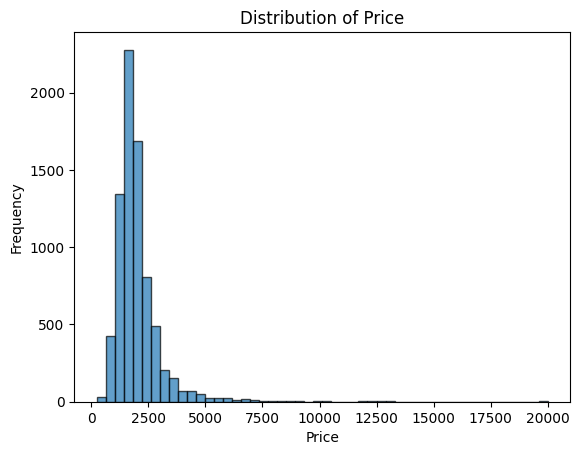

count     7757.000000
mean      2015.252675
std       1096.261037
min        250.000000
25%       1460.000000
50%       1790.000000
75%       2250.000000
max      20000.000000
Name: Price, dtype: float64


In [4]:
# Plot of the distribution of the target variable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Overview of the statistical metrics of the target variable
price_stats = df['Price'].describe()
print(price_stats)


<a id="7"></a>
### Exclude Extreme Values

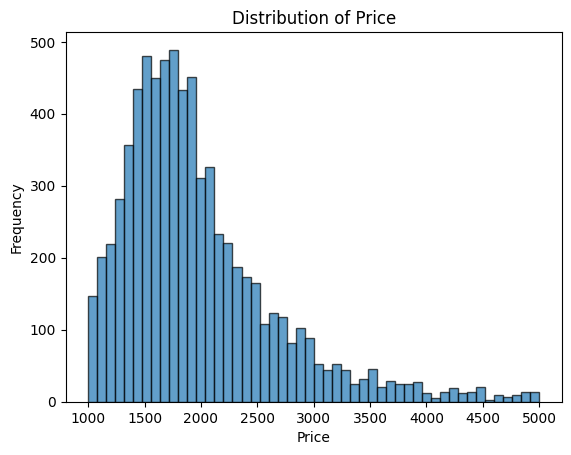

count    7223.000000
mean     1968.947944
std       684.813459
min      1000.000000
25%      1500.000000
50%      1810.000000
75%      2245.000000
max      5000.000000
Name: Price, dtype: float64


In [5]:
df = df.loc[(df['Price'] >= 1000) & 
            (df['Price'] <= 5000)]

# Plot of the distribution of the target variable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Overview of the statistical metrics of the target variable
price_stats = df['Price'].describe()
print(price_stats)


<a id="8"></a>
## Model creation

<a id="9"></a>
### Split data and train

In [6]:
# X(independent variable) and y(Target variable)
X = df.drop(columns=['Price', 'Price_per_m2'])
y = df['Price'].values

# The splitting of data between training and test data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)


<a id="10"></a>
### Multiple Linear Regression

In [7]:
# Save the columns
feature_names = X.columns

# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_score = mlr.score(X_test, y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(y_test, pred_mlr)


# Extract the coefficients of the model.
coefficients = mlr.coef_

# Create a DataFrame for the feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients and select the top 10
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)



<a id="11"></a>
### Decision Tree Regressor

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples

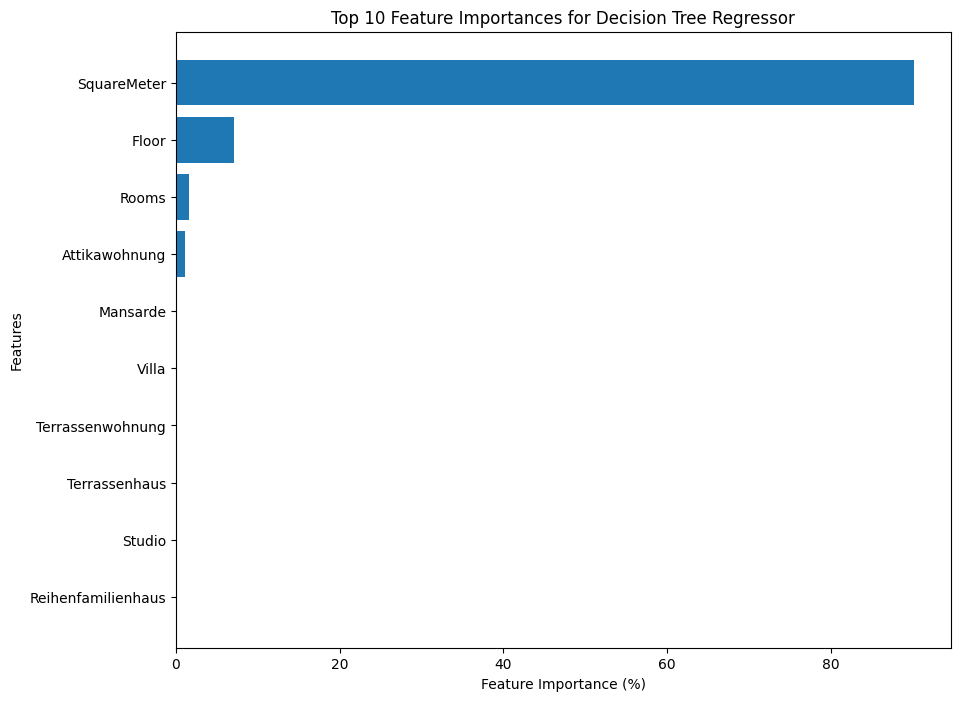

MSE: 294908.8451031017
RMSE: 543.0551031922098
MAE: 381.17041660962985
R²: 0.3545163175065381
Explained variance: 0.35455941754519305
Decision Tree Regressor Score: 35%


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the hyperparameters to optimize
dt_param_grid = {
    'max_depth': list(range(5, 30, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Decision Tree Regressor object
dt_regressor = DecisionTreeRegressor(random_state=0)

# Set up GridSearchCV
dt_grid_search = GridSearchCV(estimator=dt_regressor, param_grid=dt_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Train the model
dt_grid_search.fit(X_train, y_train)
dt_best_model = dt_grid_search.best_estimator_
print(f"Best parameters for DecisionTree: {dt_grid_search.best_params_}")

# Evaluate the best model
dt_best_pred = dt_best_model.predict(X_test)
dt_best_score = explained_variance_score(y_test, dt_best_pred)
print(f"Explained variance of the best DecisionTree model: {dt_best_score}")

# Feature importances for DecisionTreeRegressor
dt_importances = dt_best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Convert importances to percentages
top_features['Importance'] = top_features['Importance'] * 100

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances for Decision Tree Regressor")
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()

# Calculate and print MSE, RMSE, MAE, and R² for the Decision Tree model
mse_best_dt = mean_squared_error(y_test, dt_best_pred)
rmse_best_dt = np.sqrt(mse_best_dt)
mae_best_dt = mean_absolute_error(y_test, dt_best_pred)
r2_best_dt = r2_score(y_test, dt_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
dtr_score = round(dt_best_model.score(X_test, y_test) * 100)

print(f"MSE: {mse_best_dt}")
print(f"RMSE: {rmse_best_dt}")
print(f"MAE: {mae_best_dt}")
print(f"R²: {r2_best_dt}")
print(f"Explained variance: {expl_dt}")
print(f"Decision Tree Regressor Score: {dtr_score}%")


<a id="12"></a>
### Random Forest Regressor

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END

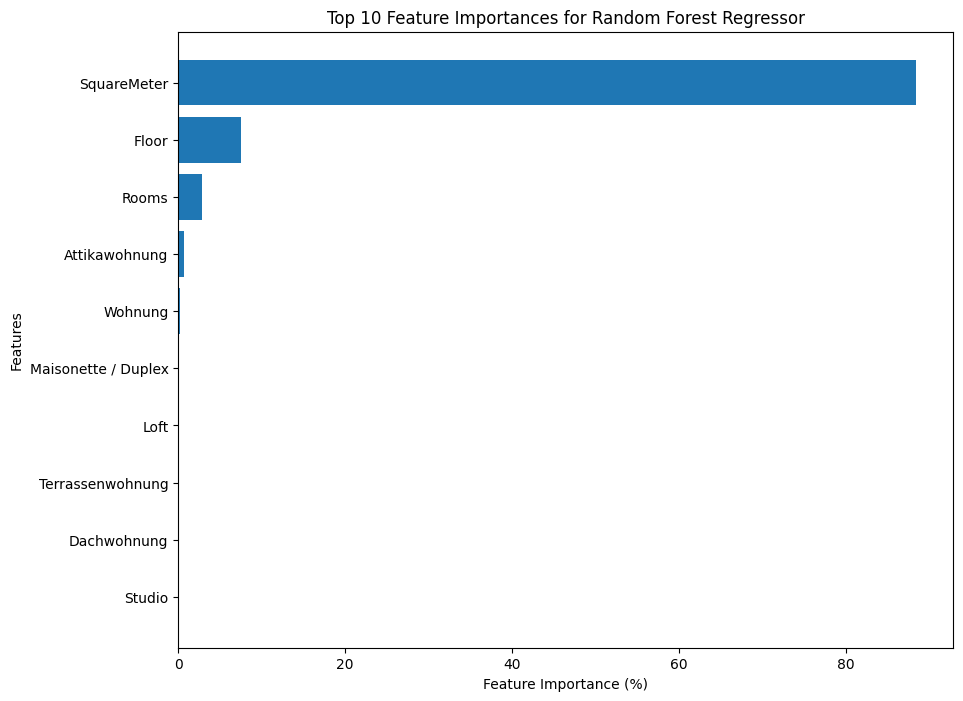

MSE: 286075.07327493414
RMSE: 534.8598632117895
MAE: 375.9979237920229
R²: 0.3738512939395411


In [9]:
# Define the hyperparameters to optimize
rf_param_grid = {
    'n_estimators': list(range(100, 600, 100)),  
    'max_depth': list(range(5, 30, 5)),  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the Random Forest Regressor object
rf_regressor = RandomForestRegressor(random_state=0)

# Set up GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_regressor, param_grid=rf_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Train the model
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Best parameters for RandomForest: {rf_grid_search.best_params_}")

# Evaluate the best model
rf_best_pred = rf_best_model.predict(X_test)
rf_best_score = explained_variance_score(y_test, rf_best_pred)
print(f"Explained variance of the best RandomForest model: {rf_best_score}")

forest_importances = rf_best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': forest_importances
})

# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Convert importances to percentages
top_features['Importance'] = top_features['Importance'] * 100

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature Importance (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances for Random Forest Regressor")
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

# Calculate and print MSE, RMSE, MAE, and R²
mse_best_rf = mean_squared_error(y_test, rf_best_pred)
rmse_best_rf = np.sqrt(mse_best_rf)
mae_best_rf = mean_absolute_error(y_test, rf_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)

print(f"MSE: {mse_best_rf}")
print(f"RMSE: {rmse_best_rf}")
print(f"MAE: {mae_best_rf}")
print(f"R²: {r2_best_rf}")


<a id="13"></a>
### XGBOOST

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5

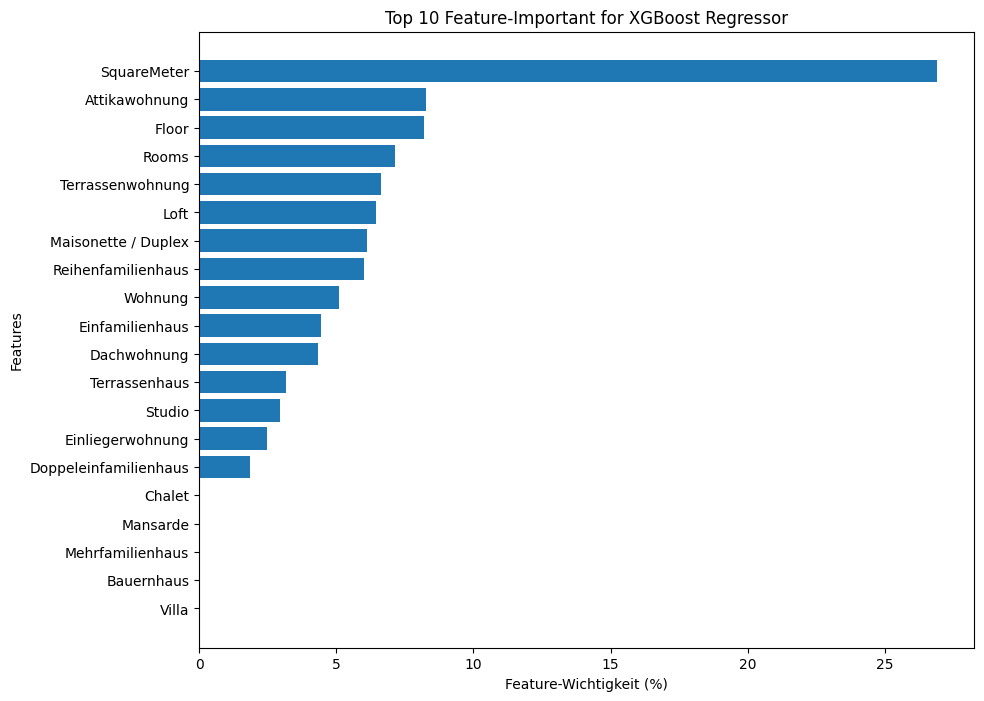

In [10]:
# Define the hyperparameters to optimize
xgb_param_grid = {
    'n_estimators': list(range(100, 600, 100)),
    'max_depth': list(range(5, 30, 5)),
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Create the XGBRegressor object
xgb_regressor = XGBRegressor(random_state=0)

# Set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Train the model
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Beste Parameter für XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluate the best model
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Erklärte Varianz des besten XGBRegressor-Modells: {xgb_best_score}")

# Feature importances for XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})


# Sort the features by importance and select the top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False)

# Convert Importance in percentage 
top_features['Importance'] = top_features['Importance'] * 100

# Plot Feature Important
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature-Wichtigkeit (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature-Important for XGBoost Regressor")
plt.gca().invert_yaxis() 
plt.show()

## Calculate and print MSE, RMSE, MAE, and R² for the XGBoost model
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)


<a id="14"></a>
## Evaluate model

In [11]:
# MeanSquaredError, RootMeanedSquaredErro & MeanAbsolutError,

expl_rf = explained_variance_score(y_test, rf_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)

# MeanSquaredError und RootMeanedSquaredErro und MeanAbsolutError, RScored.
print("Multiple Linear Regression Model Score is ",round(mlr.score(X_test,y_test)*100))
print("Decision tree  Regression Model Score is ",round(dtr_score))
print("Random Forest Regression Model Score is ",round(r2_best_rf * 100))
print("XGBoost Regression Model Score is ", round(xgb_best_score * 100))


#Let's have a tabular pandas data frame, for a clear comparison

models_score =pd.DataFrame({'Model':['Multiple Linear Regression','Decision Tree','Random forest Regression','XGB Boost'],
                            'Score':[mlr_score,r2_best_dt * 100 ,dtr_score * 100,r2_best_xgb * 100],
                            'Explained Variance Score':[expl_mlr,expl_dt,expl_rf,mae_best_xgb]
                          })
models_score.sort_values(by='Score',ascending=False)


# reate a ranking of the models in a table.
models_score = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Mean Squared Error (MSE):': [mse_best_dt, mse_best_rf, mse_best_xgb],
    'Root Mean Squared Error (RMSE)': [rmse_best_dt, rmse_best_rf, rmse_best_xgb],
    'Mean Absolute Error (MAE)': [mae_best_dt, mae_best_rf, mae_best_xgb],
    'R Squared (R2)': [r2_best_dt, r2_best_rf, r2_best_xgb]
})


# Sort the table by the error metrics.
models_score = models_score.sort_values(by=['Mean Squared Error (MSE):', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R Squared (R2)'], ascending=True)
models_score

Multiple Linear Regression Model Score is  36
Decision tree  Regression Model Score is  35
Random Forest Regression Model Score is  37
XGBoost Regression Model Score is  37


,Model,Mean Squared Error (MSE):,Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R Squared (R2)
1,Random Forest,286075.073275,534.859863,375.997924,0.373851
2,XGBoost,287975.149380,536.633161,377.236666,0.369692
0,Decision Tree,294908.845103,543.055103,381.170417,0.354516


<a id="15"></a>
## Save Model

In [12]:
# import joblib

# model = xgb_best_model
# ref_cols=list(X.columns)
# target = 'Price'

# joblib.dump(value=[model, ref_cols, target], filename='XGBoost_model.pkl')